## Applies COMMOT to HVGs, SVGs, and unfiltered expression data set for mouse brain ST 

In [55]:
import pandas as pd
import numpy as np
import scanpy as sc
import commot as ct
import os
import pyreadr
import rpy2
from rpy2.robjects.packages import importr
import anndata as ad
import copy
from collections import defaultdict
from scipy import sparse

np.random.seed(42)

### Prepare data for COMMOT input
- align by barcode 
- get non negative expression matrix

In [8]:
# load in mouse seurat object
mouse_seurat = os.path.join("/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/seurat_objs", "mousebrain_seurat.rds")

# read in mouse seurat object
base = importr('base')
seurat_obj = base.readRDS(mouse_seurat)


In [9]:
# load in mouse data HVGs and SVGs - using unLR filtered data
# sorted by p value in ascending order
hvg_gene_cell_mat = os.path.join("/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/hvgs", "mouse_hvg_gene_cell_matrix.csv")
svg_gene_cell_mat = os.path.join("/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/svgs", "nnSVG_mouse_svg_gene_cell_matrix.csv")

In [10]:
# check first lines of HVG and SVG gene cell matrices
hvg_df = pd.read_csv(hvg_gene_cell_mat, index_col=0)
svg_df = pd.read_csv(svg_gene_cell_mat, index_col=0)

hvg_df.head() # gene by spot matrix
#svg_df.head()

,AAACAAGTATCTCCCA.1,AAACAGAGCGACTCCT.1,AAACAGGGTCTATATT.1,AAACATTTCCCGGATT.1,AAACCCGAACGAAATC.1,AAACCGGAAATGTTAA.1,AAACCGGGTAGGTACC.1,AAACGAGACGGTTGAT.1,AAACTGCTGGCTCCAA.1,AAACTTGCAAACGTAT.1,...,TTGTGAGGCATGACGC.1,TTGTGCAGCCACGTCA.1,TTGTGGCCCTGACAGT.1,TTGTGTATGCCACCAA.1,TTGTGTTTCCCGAAAG.1,TTGTTAGCAAATTCGA.1,TTGTTCAGTGTGCTAC.1,TTGTTGTGTGTCAAGA.1,TTGTTTCATTAGTCTA.1,TTGTTTCCATACAACT.1
Ttr,1.609438,0.000000,1.098612,0.693147,6.200509,1.609438,1.098612,2.197225,1.791759,0.000000,...,0.693147,1.386294,0.693147,1.386294,1.386294,0.000000,0.000000,1.098612,2.397895,1.098612
Ptgds,2.397895,5.252273,3.871201,2.197225,5.398163,3.555348,2.079442,2.564949,5.176150,3.663562,...,2.079442,2.995732,2.397895,5.991465,6.785588,2.564949,5.135798,1.609438,2.079442,2.772589
Plp1,5.446737,0.693147,4.454347,5.863631,5.003946,4.204693,2.639057,1.791759,2.484907,3.951244,...,2.890372,5.583496,1.386294,4.634729,1.609438,3.044522,2.708050,0.693147,3.850148,4.143135
Pcp2,0.693147,3.583519,0.000000,0.693147,1.386294,0.000000,0.000000,2.079442,1.386294,0.000000,...,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,1.098612,4.158883,0.000000,0.000000
Car8,0.000000,2.639057,0.000000,1.098612,0.693147,0.000000,0.693147,0.693147,0.000000,0.000000,...,0.000000,1.098612,0.000000,0.000000,0.000000,0.000000,0.693147,3.931826,0.693147,0.000000


In [11]:
# convert matrices to gene lists
SVG = set(svg_df.index.tolist())
HVG = set(hvg_df.index.tolist())

In [12]:
# look at lists
print(f"First 10 HVGs: {list(HVG)[:10]}")
print(f"First 10 SVGs: {list(SVG)[:10]}")

First 10 HVGs: ['Col1a1', 'Rpl9', 'Usp34', 'Hnrnpul2', 'Hnrnph3', 'Ina', 'Fgd4', 'Brd4', 'Rsl1d1', 'Ctsd']
First 10 SVGs: ['Col1a1', 'Rpl9', 'Usp34', 'Hnrnpul2', 'Hnrnph3', 'Ina', 'Stip1', 'Fgd4', 'Brd4', 'Rsl1d1']


In [13]:
# get non negative expression and coordiantes from mouse seurat

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

# load in seurat object
ro.r('library(Seurat)')
ro.r('obj <- readRDS("/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/seurat_objs/mousebrain_seurat.rds")')

R callback write-console: Loading required package: SeuratObject
  
R callback write-console: Loading required package: sp
  
R callback write-console: 
Attaching package: ‘SeuratObject’

  
R callback write-console: The following objects are masked from ‘package:base’:

    intersect, t

  



    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [14]:
# look for images slot
print(ro.r('head(colnames(obj@meta.data), 50)'))  # show first 50 meta columns

 [1] "orig.ident"   "nCount_RNA"   "nFeature_RNA" "cell_id"      "x"           
 [6] "y"            "percent.mt"   "imagerow"     "imagecol"     "nCount_SCT"  
[11] "nFeature_SCT"



In [20]:
# Get meta.data with rownames kept as a column
md = ro.r('''
md <- obj@meta.data
md$barcode <- rownames(md)
md[, c("barcode", "cell_id", "imagecol", "imagerow", "x", "y")]
''')
md = pandas2ri.rpy2py(md)

# check types 
md["barcode"] = md["barcode"].astype(str)
md["cell_id"] = md["cell_id"].astype(str)
md = md.dropna(subset=["cell_id"])

# check matches between svg spot ids and meta data cell ids/barcodes
spot_ids_csv = pd.Index(svg_df.columns.astype(str))

# check matches
n_match_cellid = spot_ids_csv.isin(pd.Index(md["cell_id"])).sum()
n_match_barcode = spot_ids_csv.isin(pd.Index(md["barcode"])).sum()

print("CSV -> cell_id matches:", n_match_cellid, "of", len(spot_ids_csv))
print("CSV -> barcode matches:", n_match_barcode, "of", len(spot_ids_csv))

CSV -> cell_id matches: 1640 of 1640
CSV -> barcode matches: 1640 of 1640


In [21]:
# show spot ids
print("CSV examples:", spot_ids_csv[:20].tolist())


CSV examples: ['AAACAAGTATCTCCCA-1', 'AAACAGAGCGACTCCT-1', 'AAACAGGGTCTATATT-1', 'AAACATTTCCCGGATT-1', 'AAACCCGAACGAAATC-1', 'AAACCGGAAATGTTAA-1', 'AAACCGGGTAGGTACC-1', 'AAACGAGACGGTTGAT-1', 'AAACTGCTGGCTCCAA-1', 'AAACTTGCAAACGTAT-1', 'AAAGCTTGCCTACATA-1', 'AAAGTGTGATTTATCT-1', 'AAAGTTGACTCCCGTA-1', 'AAATAAGGTAGTGCCC-1', 'AAATACCTATAAGCAT-1', 'AAATAGCTTAGACTTT-1', 'AAATAGGGTGCTATTG-1', 'AAATCGCGGAAGGAGT-1', 'AAATCTAGCCCTGCTA-1', 'AAATGATTCGATCAGC-1']


In [22]:
# get seurat barcodes
seurat_barcodes = list(ro.r('rownames(obj@meta.data)'))
seurat_barcodes = [str(x) for x in seurat_barcodes]

print("Seurat n spots:", len(seurat_barcodes))
print("CSV n spots:", svg_df.shape[1])

Seurat n spots: 1640
CSV n spots: 1640


In [23]:
# map csv columns to seurat barcodes by order
assert svg_df.shape[1] == len(seurat_barcodes), "Counts differ —> can't map by order"

# rename csv columns to seurat barcodes
svg_df.columns = seurat_barcodes
hvg_df.columns = seurat_barcodes


In [24]:
# show renamed svg spot ids
print(pd.Index(svg_df.columns.astype(str))[:20].tolist())

# check overlap between seurat barcodes and csv barcodes
seurat_barcodes = pd.Index([str(x) for x in ro.r('colnames(obj)')])
csv_barcodes = pd.Index(svg_df.columns.astype(str))

print("Seurat n:", len(seurat_barcodes))
print("CSV n:", len(csv_barcodes))
print("Overlap:", len(seurat_barcodes.intersection(csv_barcodes)))
print("Seurat example:", seurat_barcodes[:5].tolist())

['AAACAAGTATCTCCCA-1', 'AAACAGAGCGACTCCT-1', 'AAACAGGGTCTATATT-1', 'AAACATTTCCCGGATT-1', 'AAACCCGAACGAAATC-1', 'AAACCGGAAATGTTAA-1', 'AAACCGGGTAGGTACC-1', 'AAACGAGACGGTTGAT-1', 'AAACTGCTGGCTCCAA-1', 'AAACTTGCAAACGTAT-1', 'AAAGCTTGCCTACATA-1', 'AAAGTGTGATTTATCT-1', 'AAAGTTGACTCCCGTA-1', 'AAATAAGGTAGTGCCC-1', 'AAATACCTATAAGCAT-1', 'AAATAGCTTAGACTTT-1', 'AAATAGGGTGCTATTG-1', 'AAATCGCGGAAGGAGT-1', 'AAATCTAGCCCTGCTA-1', 'AAATGATTCGATCAGC-1']
Seurat n: 1640
CSV n: 1640
Overlap: 1640
Seurat example: ['AAACAAGTATCTCCCA-1', 'AAACAGAGCGACTCCT-1', 'AAACAGGGTCTATATT-1', 'AAACATTTCCCGGATT-1', 'AAACCCGAACGAAATC-1']


In [25]:
# get coordinates
coords = ro.r('''
md <- obj@meta.data
md[, c("imagecol","imagerow")]
''')
coords = pandas2ri.rpy2py(coords)
coords.index = coords.index.astype(str)
coords.columns = ["x", "y"]  


print(coords.head()) # cell ID by location

                         x       y
AAACAAGTATCTCCCA-1  7410.0  8455.0
AAACAGAGCGACTCCT-1  3097.0  7905.0
AAACAGGGTCTATATT-1  7050.0  2327.0
AAACATTTCCCGGATT-1  8728.0  8111.0
AAACCCGAACGAAATC-1  6811.0  9351.0


In [26]:
# get counts
expr_df = ro.r('''
mat <- NULL
try({ mat <- GetAssayData(obj, assay="SCT", slot="counts") }, silent=TRUE)
if (is.null(mat)) {
  try({ mat <- GetAssayData(obj, assay="SCT", layer="counts") }, silent=TRUE)
}
if (is.null(mat)) stop("Couldn't access SCT counts.")
as.data.frame(as.matrix(mat))
''')
expr_df = pandas2ri.rpy2py(expr_df)
expr_df.index = expr_df.index.astype(str) # genes
expr_df.columns = expr_df.columns.astype(str)  # barcodes

print("expr_df shape (genes x spots):", expr_df.shape)
print(expr_df.head())  # first 5 spots

expr_df shape (genes x spots): (16112, 1640)
        AAACAAGTATCTCCCA-1  AAACAGAGCGACTCCT-1  AAACAGGGTCTATATT-1  \
Xkr4                   0.0                 0.0                 0.0   
Sox17                  0.0                 0.0                 0.0   
Mrpl15                 0.0                 1.0                 1.0   
Lypla1                 0.0                 0.0                 0.0   
Tcea1                  0.0                 1.0                 0.0   

        AAACATTTCCCGGATT-1  AAACCCGAACGAAATC-1  AAACCGGAAATGTTAA-1  \
Xkr4                   0.0                 0.0                 0.0   
Sox17                  0.0                 0.0                 1.0   
Mrpl15                 0.0                 0.0                 1.0   
Lypla1                 0.0                 0.0                 0.0   
Tcea1                  2.0                 0.0                 0.0   

        AAACCGGGTAGGTACC-1  AAACGAGACGGTTGAT-1  AAACTGCTGGCTCCAA-1  \
Xkr4                   0.0                 

In [27]:
# align by barcodes
common = csv_barcodes.intersection(expr_df.columns).intersection(coords.index)
print("Common spots:", len(common))

# subset to common spots
expr_df = expr_df.loc[:, common]
coords_sub = coords.loc[common]

# nonnegative expression for COMMOT
expr_df = np.log1p(expr_df)

# spots x genes
spot_gene_mat = expr_df.T
print("Spots by gene shape:", spot_gene_mat.shape)

Common spots: 1640
Spots by gene shape: (1640, 16112)


In [28]:
# build AnnData object for COMMOT

adata = ad.AnnData(X=spot_gene_mat.values)
adata.obs_names = spot_gene_mat.index.astype(str)
adata.var_names = spot_gene_mat.columns.astype(str)
adata.obsm["spatial"] = coords_sub.loc[adata.obs_names, ["x","y"]].values

print("adata:", adata.shape)
print("spatial:", adata.obsm["spatial"].shape)
print("X min:", adata.X.min())

adata: (1640, 16112)
spatial: (1640, 2)
X min: 0.0


### Filter for LR pairs using CellChat

In [29]:
# get mouse LR pairs from CellChat
df_lr = ct.pp.ligand_receptor_database(database="CellChat", species="Mouse")

# filter for LR pairs present in data
df_lr_expr = ct.pp.filter_lr_database(df_lr, adata, heteromeric=True, heteromeric_delimiter="_",
                                      heteromeric_rule="min", filter_criteria="min_cell_pct",
                                      min_cell_pct=0.05)

# SVG/HVG filtering
def receptor_in_set(rec, geneset):
    return any(p in geneset for p in str(rec).split("_"))

df_lr_svg = df_lr_expr[df_lr_expr.iloc[:,0].isin(SVG) | df_lr_expr.iloc[:,1].apply(lambda r: receptor_in_set(r, SVG))].copy()
df_lr_hvg = df_lr_expr[df_lr_expr.iloc[:,0].isin(HVG) | df_lr_expr.iloc[:,1].apply(lambda r: receptor_in_set(r, HVG))].copy()

# LR df for unfiltered data
df_lr_unfiltered = ct.pp.filter_lr_database(df_lr, adata, heteromeric=True, heteromeric_delimiter="_",
                                      heteromeric_rule="min", filter_criteria="none")

In [30]:
# look at lr dataframes
print("SVG LR dataframe:")
print(df_lr_svg.head())
print("n LR pairs:", df_lr_svg.shape[0])

SVG LR dataframe:
       0              1     2                   3
0  Tgfb1  Tgfbr1_Tgfbr2  TGFb  Secreted Signaling
1  Tgfb2  Tgfbr1_Tgfbr2  TGFb  Secreted Signaling
2  Tgfb3  Tgfbr1_Tgfbr2  TGFb  Secreted Signaling
3  Tgfb1  Acvr1b_Tgfbr2  TGFb  Secreted Signaling
4  Tgfb1  Acvr1c_Tgfbr2  TGFb  Secreted Signaling
n LR pairs: 169


In [31]:
print("HVG LR dataframe:")
print(df_lr_hvg.head())
print("n LR pairs:", df_lr_hvg.shape[0])

HVG LR dataframe:
       0              1     2                   3
0  Tgfb1  Tgfbr1_Tgfbr2  TGFb  Secreted Signaling
1  Tgfb2  Tgfbr1_Tgfbr2  TGFb  Secreted Signaling
2  Tgfb3  Tgfbr1_Tgfbr2  TGFb  Secreted Signaling
3  Tgfb1  Acvr1b_Tgfbr2  TGFb  Secreted Signaling
4  Tgfb1  Acvr1c_Tgfbr2  TGFb  Secreted Signaling
n LR pairs: 169


In [32]:
print("Unfiltered LR dataframe:")
print(df_lr_unfiltered.head())
print("n LR pairs:", df_lr_unfiltered.shape[0])

Unfiltered LR dataframe:
       0              1     2                   3
0  Tgfb1  Tgfbr1_Tgfbr2  TGFb  Secreted Signaling
1  Tgfb2  Tgfbr1_Tgfbr2  TGFb  Secreted Signaling
2  Tgfb3  Tgfbr1_Tgfbr2  TGFb  Secreted Signaling
3  Tgfb1  Acvr1b_Tgfbr2  TGFb  Secreted Signaling
4  Tgfb1  Acvr1c_Tgfbr2  TGFb  Secreted Signaling
n LR pairs: 589


TGF-beta signaling is highly enriched in SVGs, HVGs, and the unfiltered expression datasets. In the context of the brain, this pathway in involved in neuronal development, microgial function, synaptic plasticity, and injury response. This pathway also plays a role in cell growth, differentiation, and axon guidance. 

In [34]:
# ligand/receptor columns
lig_col = df_lr.columns[0]
rec_col = df_lr.columns[2]

print(f"First 10 ligand names: {df_lr[lig_col].dropna().astype(str).tolist()[:10]}")
print(f"First 10 receptor names: {df_lr[rec_col].dropna().astype(str).tolist()[:10]}")

def split_parts(x):
    if pd.isna(x):
        return []
    # if receptor stored as list/tuple/set
    if isinstance(x, (list, tuple, set)):
        parts = []
        for y in x:
            parts.extend(str(y).split("_"))
        return parts
    return str(x).split("_")

lr_ligands = set(df_lr[lig_col].dropna().astype(str))
lr_receptors = set(p for r in df_lr[rec_col].dropna() for p in split_parts(r))
lr_genes = lr_ligands | lr_receptors

print("Using columns:", lig_col, rec_col)
print("LR genes:", len(lr_genes))
print("LR ∩ SVG:", len(lr_genes & SVG))
print("LR ∩ HVG:", len(lr_genes & HVG))
print("LR ∩ SVG ∩ HVG:", len(lr_genes & SVG & HVG))
print("SVG-only within LR:", len((lr_genes & SVG) - HVG))
print("HVG-only within LR:", len((lr_genes & HVG) - SVG))


First 10 ligand names: ['Tgfb1', 'Tgfb2', 'Tgfb3', 'Tgfb1', 'Tgfb1', 'Tgfb2', 'Tgfb2', 'Tgfb3', 'Tgfb3', 'Tgfb1']
First 10 receptor names: ['TGFb', 'TGFb', 'TGFb', 'TGFb', 'TGFb', 'TGFb', 'TGFb', 'TGFb', 'TGFb', 'TGFb']
Using columns: 0 2
LR genes: 502
LR ∩ SVG: 69
LR ∩ HVG: 93
LR ∩ SVG ∩ HVG: 64
SVG-only within LR: 5
HVG-only within LR: 29


In [35]:
# colnames in lr df
LIG = "0"
REC = "1"
PATH = "2"
CAT = "3"  

# make copies & ensure strings
lr_df = df_lr.copy()
lr_df[LIG] = lr_df[LIG].astype(str)
lr_df[REC] = lr_df[REC].astype(str)

varset = set(adata.var_names)

def receptor_parts(rec: str):
    # heteromeric receptors are encoded as "A_B_C"
    return str(rec).split("_")

def receptor_in_var(rec: str) -> bool:
    parts = receptor_parts(rec)
    return any(p in varset for p in parts)

def receptor_in_set(rec: str, geneset: set) -> bool:
    parts = receptor_parts(rec)
    return any(p in geneset for p in parts)

# filter LR pairs to those present in the dataset
lr_expr = lr_df[
    lr_df[LIG].isin(varset) &
    lr_df[REC].apply(receptor_in_var)
].copy()

# SVG / HVG LR filters 
lr_svg = lr_expr[
    lr_expr[LIG].isin(SVG) |
    lr_expr[REC].apply(lambda r: receptor_in_set(r, SVG))
].copy()

lr_hvg = lr_expr[
    lr_expr[LIG].isin(HVG) |
    lr_expr[REC].apply(lambda r: receptor_in_set(r, HVG))
].copy()

print("LR total:", lr_df.shape)
print("LR expressed in data:", lr_expr.shape)
print("LR SVG-filtered:", lr_svg.shape)
print("LR HVG-filtered:", lr_hvg.shape)


LR total: (1209, 4)
LR expressed in data: (596, 4)
LR SVG-filtered: (484, 4)
LR HVG-filtered: (519, 4)


## Use stricter rules on LR filtering pairings
- ligand and receptor must be an SVG or HVG
- ligand must be a SVG or HVG
- receptor must be a SVG or HVG
- prevalence:
    - ligand and at least one receptor part expressed in at least 5% of spots

In [36]:
# filter based on LR both must be SVG or HVG
lr_svg_strict = lr_expr[
    lr_expr[LIG].isin(SVG) &
    lr_expr[REC].apply(lambda r: all(p in SVG for p in receptor_parts(r)))
].copy()

lr_hvg_strict = lr_expr[
    lr_expr[LIG].isin(HVG) &
    lr_expr[REC].apply(lambda r: all(p in HVG for p in receptor_parts(r)))
].copy()

print("LR SVG-strict filtered:", lr_svg_strict.shape)
print("LR HVG-strict filtered:", lr_hvg_strict.shape)

LR SVG-strict filtered: (116, 4)
LR HVG-strict filtered: (152, 4)


In [37]:
# filter based on ligand must be SVG or HVG
lr_svg_ligand = lr_expr[lr_expr[LIG].isin(SVG)].copy()
lr_hvg_ligand = lr_expr[lr_expr[LIG].isin(HVG)].copy()

print("LR SVG-ligand filtered:", lr_svg_ligand.shape)
print("LR HVG-ligand filtered:", lr_hvg_ligand.shape)

LR SVG-ligand filtered: (250, 4)
LR HVG-ligand filtered: (321, 4)


In [38]:
# filter based on receptor must be SVG or HVG
lr_svg_receptor = lr_expr[lr_expr[REC].apply(lambda r: receptor_in_set(r, SVG))].copy()
lr_hvg_receptor = lr_expr[lr_expr[REC].apply(lambda r: receptor_in_set(r, HVG))].copy()

print("LR SVG-receptor filtered:", lr_svg_receptor.shape)
print("LR HVG-receptor filtered:", lr_hvg_receptor.shape)

LR SVG-receptor filtered: (421, 4)
LR HVG-receptor filtered: (450, 4)


In [41]:
# filter based on prevalence: ligand and at least one receptor part expressed in at least 5% of spots
Xdf = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
pct_expr = (Xdf > 0).mean(axis=0)

min_pct = 0.05  # 5% of spots

def pair_prevalence_ok(df):
    lig_ok = df[LIG].map(lambda g: pct_expr.get(g, 0) >= min_pct)
    rec_ok = df[REC].map(lambda r: any(pct_expr.get(p, 0) >= min_pct for p in receptor_parts(r)))
    return df[lig_ok & rec_ok].copy()

prevalence_lr_expr = pair_prevalence_ok(lr_expr)
prevalence_lr_svg = pair_prevalence_ok(lr_svg)
prevalence_lr_hvg = pair_prevalence_ok(lr_hvg)

print("After prevalence filtering:")
print("LR expressed in data:", prevalence_lr_expr.shape)
print("LR SVG-filtered:", prevalence_lr_svg.shape)
print("LR HVG-filtered:", prevalence_lr_hvg.shape)

After prevalence filtering:
LR expressed in data: (261, 4)
LR SVG-filtered: (256, 4)
LR HVG-filtered: (261, 4)


## Apply OT

### SVGs
- simple SVGs
- L&R SVG
- Ligand SVG
- Receptor SVG
- 5% prevalence

In [ ]:
# SVG LR sets
svg_lr_sets = {
    "simple_svg": lr_svg,
    "LR_svg" : lr_svg_strict,
    "L_svg" : lr_svg_ligand,
    "R_svg" : lr_svg_receptor,
    "prevalence_svg" : prevalence_lr_svg,
}

svg_results = {}

# run COMMOT for each LR set
for name, df in svg_lr_sets.items():
    ad = adata.copy()  # use shallow copy
    ct.tl.spatial_communication(
        adata=ad,
        database_name="cellchat",
        df_ligrec=df,
        dis_thr=500,
        heteromeric=True,
        pathway_sum=True,
    )
    # store results
    svg_results[name] = ad

print(svg_results.keys())


dict_keys(['simple_svg', 'LR_svg', 'L_svg', 'R_svg', 'prevalence_svg:'])


In [52]:
# look at COMMOT outputs for SVG sets

def commot_inventory(ad):
    return {
        "n_obs": ad.n_obs,
        "n_vars": ad.n_vars,
        "n_obsp": len(ad.obsp.keys()),
        "obsp_keys_head": list(ad.obsp.keys())[:15],
        "uns_keys_head": list(ad.uns.keys())[:15],
    }

print("COMMOT results for SVG LR sets:")
for name, ad in svg_results.items():
    inv = commot_inventory(ad)
    print("\n==", name, "==")
    print("n_obsp:", inv["n_obsp"])
    print("obsp head:", inv["obsp_keys_head"])


COMMOT results for SVG LR sets:

== simple_svg ==
n_obsp: 297
obsp head: ['commot-cellchat-Tgfb2-Acvr1b_Tgfbr2', 'commot-cellchat-Tgfb2-Tgfbr1_Tgfbr2', 'commot-cellchat-Tgfb2-Acvr1c_Tgfbr2', 'commot-cellchat-Tgfb2-Acvr1_Tgfbr1_Tgfbr2', 'commot-cellchat-Nppc-Npr2', 'commot-cellchat-Pros1-Tyro3', 'commot-cellchat-Pros1-Axl', 'commot-cellchat-Tgfb3-Acvr1b_Tgfbr2', 'commot-cellchat-Tgfb3-Tgfbr1_Tgfbr2', 'commot-cellchat-Tgfb3-Acvr1c_Tgfbr2', 'commot-cellchat-Tgfb3-Acvr1_Tgfbr1_Tgfbr2', 'commot-cellchat-Igf2-Igf1r', 'commot-cellchat-Igf2-Igf2r', 'commot-cellchat-Igf2-Itgav_Itgb3', 'commot-cellchat-Igf2-Itga6_Itgb4']

== LR_svg ==
n_obsp: 307
obsp head: ['commot-cellchat-Tgfb2-Acvr1b_Tgfbr2', 'commot-cellchat-Tgfb2-Tgfbr1_Tgfbr2', 'commot-cellchat-Tgfb2-Acvr1c_Tgfbr2', 'commot-cellchat-Tgfb2-Acvr1_Tgfbr1_Tgfbr2', 'commot-cellchat-Nppc-Npr2', 'commot-cellchat-Pros1-Tyro3', 'commot-cellchat-Pros1-Axl', 'commot-cellchat-Tgfb3-Acvr1b_Tgfbr2', 'commot-cellchat-Tgfb3-Tgfbr1_Tgfbr2', 'commot-cellch

In [53]:
# pathway-sum matrices vs LR pair matrices

def split_pathway_lr_keys(ad):
    keys = list(ad.obsp.keys())
    # pathway matrices typically have much larger nnz and fewer keys overall;
    # also often contain "pathway" or "sum" in key names (depends on version).
    path_keys = [k for k in keys if ("path" in k.lower()) or ("sum" in k.lower())]
    # fallback: if that fails, treat everything as LR and you can manually adjust later
    if len(path_keys) == 0:
        path_keys = []
    lr_keys = [k for k in keys if k not in path_keys]
    return path_keys, lr_keys

print("Pathway vs LR matrices for SVG LR sets:")
for name, ad in  svg_results.items():
    pk, lk = split_pathway_lr_keys(ad)
    print(name, "path:", len(pk), "lr:", len(lk))


Pathway vs LR matrices for SVG LR sets:
simple_svg path: 0 lr: 297
LR_svg path: 0 lr: 307
L_svg path: 0 lr: 364
R_svg path: 0 lr: 492
prevalence_svg path: 0 lr: 297


In [56]:
# rank pathways by total communication strength
def rank_obsp_by_total(ad, keys=None):
    if keys is None:
        keys = list(ad.obsp.keys())
    rows = []
    for k in keys:
        M = ad.obsp[k]
        total = M.sum() if sparse.issparse(M) else np.sum(M)
        rows.append((k, float(total)))
    rows.sort(key=lambda x: x[1], reverse=True)
    return rows

print("Top pathways by total communication strength for SVG LR sets:")
for name, ad in svg_results.items():
    pk, lk = split_pathway_lr_keys(ad)
    keys_to_rank = pk if len(pk) > 0 else lk
    top = rank_obsp_by_total(ad, keys_to_rank)[:10]
    print("\nTOP in", name)
    for k, s in top:
        print(f"{s: .3e}", k)


Top pathways by total communication strength for SVG LR sets:

TOP in simple_svg
 2.183e+04 commot-cellchat-total-total
 3.914e+03 commot-cellchat-PSAP
 3.229e+03 commot-cellchat-PTN
 2.554e+03 commot-cellchat-Psap-Gpr37l1
 2.107e+03 commot-cellchat-FGF
 1.695e+03 commot-cellchat-MK
 1.360e+03 commot-cellchat-Psap-Gpr37
 1.114e+03 commot-cellchat-VEGF
 8.978e+02 commot-cellchat-GAS
 8.351e+02 commot-cellchat-Ptn-Ncl

TOP in LR_svg
 2.011e+04 commot-cellchat-total-total
 3.914e+03 commot-cellchat-PSAP
 3.189e+03 commot-cellchat-PTN
 2.554e+03 commot-cellchat-Psap-Gpr37l1
 2.107e+03 commot-cellchat-FGF
 1.660e+03 commot-cellchat-MK
 1.360e+03 commot-cellchat-Psap-Gpr37
 1.025e+03 commot-cellchat-VEGF
 8.573e+02 commot-cellchat-GAS
 8.388e+02 commot-cellchat-Ptn-Ncl

TOP in L_svg
 2.130e+04 commot-cellchat-total-total
 3.914e+03 commot-cellchat-PSAP
 3.229e+03 commot-cellchat-PTN
 2.554e+03 commot-cellchat-Psap-Gpr37l1
 2.107e+03 commot-cellchat-FGF
 1.695e+03 commot-cellchat-MK
 1.360e+0

In [ ]:
# per spot LR sender and receiver scores
def add_sender_receiver(ad, key, prefix):
    M = ad.obsp[key]
    out = np.array(M.sum(axis=1)).ravel()
    inn = np.array(M.sum(axis=0)).ravel()
    ad.obs[f"{prefix}__out"] = out
    ad.obs[f"{prefix}__in"] = inn
    return out, inn

print("Adding top 3 sender/receiver scores for SVG LR sets:")
for name, ad in svg_results.items():
    pk, lk = split_pathway_lr_keys(ad)
    keys_to_rank = pk if len(pk) > 0 else lk
    top3 = [k for k, _ in rank_obsp_by_total(ad, keys_to_rank)[:3]]
    for i, k in enumerate(top3, 1):
        add_sender_receiver(ad, k, prefix=f"{name}_top{i}")


Adding top 3 sender/receiver scores for SVG LR sets:


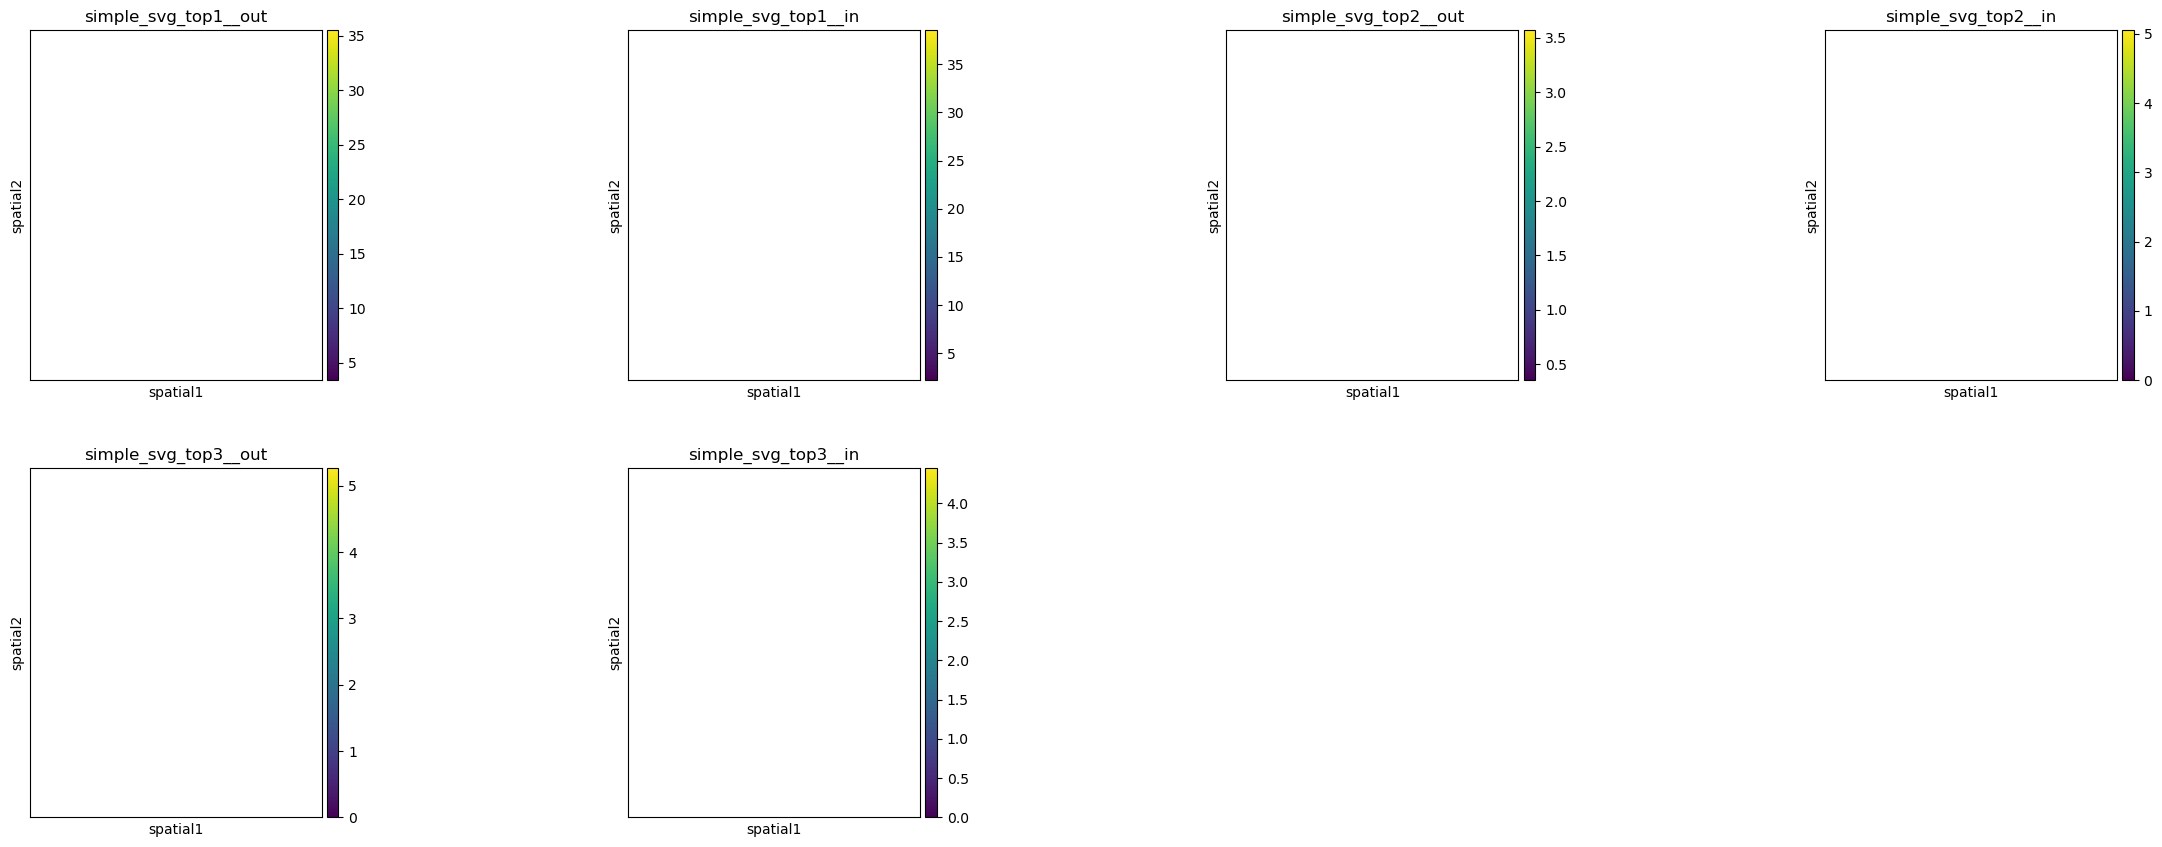

In [ ]:
# FIXME: plotting code for SVG results
# pick one run to plot
ad = svg_results["simple_svg"]
cols = [c for c in ad.obs.columns if c.startswith("simple_svg_top")]
sc.pl.spatial(ad, color=cols, spot_size=1)


In [ ]:
# compare LR sets summary table

def top_totals_table(results_dict, top_n=20):
    # get keys from first result
    ref_name = list(results_dict.keys())[0]
    ref = results_dict[ref_name]
    pk, lk = split_pathway_lr_keys(ref)
    keys = pk if len(pk) > 0 else lk

    # rank by totals in reference
    ref_rank = rank_obsp_by_total(ref, keys)[:top_n]
    top_keys = [k for k, _ in ref_rank]

    out = pd.DataFrame(index=top_keys)
    for name, ad in results_dict.items():
        vals = []
        for k in top_keys:
            if k in ad.obsp:
                M = ad.obsp[k]
                vals.append(float(M.sum() if sparse.issparse(M) else np.sum(M)))
            else:
                vals.append(0.0)
        out[name] = vals
    return out

# summary table for SVG LR sets
svg_tbl = top_totals_table(svg_results, top_n=20)
svg_tbl.style.format("{:.2e}")


,simple_svg,LR_svg,L_svg,R_svg,prevalence_svg
commot-cellchat-total-total,21832.637939,20109.351586,21296.743151,22784.478134,21832.637939
commot-cellchat-PSAP,3913.538722,3913.538722,3913.538722,3913.538722,3913.538722
commot-cellchat-PTN,3228.759158,3189.484665,3228.840643,3184.292036,3228.759158
commot-cellchat-Psap-Gpr37l1,2553.745475,2553.745475,2553.745475,2553.745475,2553.745475
commot-cellchat-FGF,2107.089305,2107.089305,2107.089305,2299.859771,2107.089305
commot-cellchat-MK,1694.770532,1660.186503,1694.770532,1665.506125,1694.770532
commot-cellchat-Psap-Gpr37,1359.793247,1359.793247,1359.793247,1359.793247,1359.793247
commot-cellchat-VEGF,1114.326582,1024.766233,1024.766233,1120.045047,1114.326582
commot-cellchat-GAS,897.766972,857.261955,897.766972,857.261955,897.766972
commot-cellchat-Ptn-Ncl,835.106316,838.839283,835.086198,839.272663,835.106316


### Top pathways for SVGs: 

### Null model (shuffled coords)

### HVGs
- simple HVGs
- L&R HVG
- ligand HVG
- receptor HVG
- 5% prevalence

In [ ]:
# HVG LR sets
hvg_lr_sets = {
    "simple_hvg": lr_hvg,
    "LR_hvg" : lr_hvg_strict,
    "L_hvg" : lr_hvg_ligand,
    "R_hvg" : lr_hvg_receptor,
    "prevalence_hvg:" : prevalence_lr_hvg,
}

hvg_results = {}

# run COMMOT for each LR set
for name, df in svg_lr_sets.items():
    ad = adata.copy()  # use shallow copy
    ct.tl.spatial_communication(
        adata=ad,
        database_name="cellchat",
        df_ligrec=df,
        dis_thr=500,
        heteromeric=True,
        pathway_sum=True,
    )
    hvg_results[name] = ad

print(hvg_results.keys())

In [ ]:
# look at results
print("COMMOT results for HVG LR sets:")
for name, ad in svg_results.items():
    inv = commot_inventory(ad)
    print("\n==", name, "==")
    print("n_obsp:", inv["n_obsp"])
    print("obsp head:", inv["obsp_keys_head"])

In [ ]:
# pathway-sum matrices vs LR pair matrices
print("Pathway vs LR matrices for HVG LR sets:")
for name, ad in  hvg_results.items():
    pk, lk = split_pathway_lr_keys(ad)
    print(name, "path:", len(pk), "lr:", len(lk))

In [ ]:
# rank pathways by total communication strength
print("Top pathways by total communication strength for HVG LR sets:")
for name, ad in hvg_results.items():
    pk, lk = split_pathway_lr_keys(ad)
    keys_to_rank = pk if len(pk) > 0 else lk
    top = rank_obsp_by_total(ad, keys_to_rank)[:10]
    print("\nTOP in", name)
    for k, s in top:
        print(f"{s: .3e}", k)

In [ ]:
# per spot sender and receiver scores for top pathway in each HVG LR set
print("Adding top 3 sender/receiver scores for HVG LR sets:")
for name, ad in hvg_results.items():
    pk, lk = split_pathway_lr_keys(ad)
    keys_to_rank = pk if len(pk) > 0 else lk
    top3 = [k for k, _ in rank_obsp_by_total(ad, keys_to_rank)[:3]]
    for i, k in enumerate(top3, 1):
        add_sender_receiver(ad, k, prefix=f"{name}_top{i}")

In [ ]:
# FIXME: plotting code for HVG results
# pick one run to plot
ad = hvg_results["simple_hvg"]
cols = [c for c in ad.obs.columns if c.startswith("simple_hvg_top")]
sc.pl.spatial(ad, color=cols, spot_size=1)

In [ ]:
# summary table for HVG LR sets
hvg_tbl = top_totals_table(hvg_results, top_n=20)
hvg_tbl.style.format("{:.2e}")

### Unfiltered expression